In [1]:
import os
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd

def initialize_firebase():
    """
    Initialize Firebase with fallback credential paths and return a Firestore client.
    """
    # Define your credential paths
    vm_path = r"C:\MasterThesis\Keys.json"
    primary_path = r"C:\Users\sajad\OneDrive\Skole\DevRepos\Master Thesis\Keys.json"
    fallback_path = r"C:\Users\Benja\OneDrive\Skole\DevRepos\Master Thesis\Keys.json"

    if not firebase_admin._apps:
        cred = None
        if os.path.exists(vm_path):
            cred = credentials.Certificate(vm_path)
        elif os.path.exists(primary_path):
            cred = credentials.Certificate(primary_path)
        elif os.path.exists(fallback_path):
            cred = credentials.Certificate(fallback_path)
        else:
            raise FileNotFoundError("Firebase credentials file not found in any of the specified paths.")
        
        firebase_admin.initialize_app(cred)

    return firestore.client()

db = initialize_firebase()

# 🧹 Extract Data from Firestore
def fetch_model_recommendations():
    try:
        collection_ref = db.collection("model_recommendations")
        docs = collection_ref.stream()
        
        data = []
        for doc in docs:
            doc_data = doc.to_dict()
            data.append(doc_data)
        
        # Convert to Pandas DataFrame
        df = pd.DataFrame(data)
        print("✅ Data fetched successfully!")
        return df
    except Exception as e:
        print(f"❌ Error fetching data: {e}")
        return pd.DataFrame()

# Fetch data
df = fetch_model_recommendations()

# Delete the "recommendation_detail" column if it exists
if "recommendation_detail" in df.columns:
    df.drop("recommendation_detail", axis=1, inplace=True)
    print("🗑️ 'recommendation_detail' column removed.")
else:
    print("ℹ️ 'recommendation_detail' column not found. No action taken.")

# Save the data to a CSV file for backup
df.to_csv("model_recommendations.csv", index=False)
print(df.head())
print("📁 Data saved to 'model_recommendations.csv' successfully!")

✅ Data fetched successfully!
🗑️ 'recommendation_detail' column removed.
  stock_ticker                                  sentiment_summary  \
0         NVDA  {'negative': 47.34950000000001, 'neutral': 45....   
1         MSFT  {'negative': 302.63780000000025, 'neutral': 29...   
2         AAPL  {'negative': 99.60730000000002, 'neutral': 112...   
3         NVDA  {'negative': 61.45169999999999, 'neutral': 56....   
4         AAPL  {'negative': 304.4951000000001, 'neutral': 309...   

   latest_close  previous_close  is_correct gpt_recommendation  \
0    133.809799      129.839996        True                Buy   
1    389.845001      354.559998        True                Buy   
2           NaN             NaN       False                Buy   
3    131.139999      132.800003       False                Buy   
4    223.134995      222.130005       False               Sell   

  aggregator_recommendation                   timestamp  experiment_day  
0                       Buy  2025-02-10T21

In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv("model_recommendations.csv")

# Replace 'Hold' recommendations in GPT with Aggregator recommendations
df.loc[df['gpt_recommendation'].str.lower() == 'hold', 'gpt_recommendation'] = df['aggregator_recommendation']

# Save the updated dataset
df.to_csv("model_recommendations.csv", index=False)

print("✅ Replaced 'Hold' recommendations and updated the dataset.")



✅ Replaced 'Hold' recommendations and updated the dataset.


In [3]:
df['experiment_day'].max()

90

In [4]:
import pandas as pd

# 1. Load the raw CSV
df = pd.read_csv("model_recommendations.csv")  # or your chosen file

# 2. Parse the timestamp column into a datetime format
df["timestamp"] = pd.to_datetime(df["timestamp"])

# 3. Extract just the date (YYYY-MM-DD) from the timestamp
df["date_only"] = df["timestamp"].dt.date

# 4. Identify duplicates using (stock_ticker + date_only), but do NOT drop them
initial_count = len(df)
df.sort_values(by=["stock_ticker", "date_only", "timestamp"], inplace=True)  # optional sort for consistent ordering
duplicate_mask = df.duplicated(subset=["stock_ticker", "date_only"], keep="first")
duplicate_count = duplicate_mask.sum()

print(f"Initial row count: {initial_count}")
print(f"Number of duplicates for the same ticker and date: {duplicate_count}")

# 5. Check for missing values
missing_values = df.isnull().sum()
total_missing = missing_values.sum()

print("\nMissing values per column:")
print(missing_values)
print(f"Total missing values: {total_missing}")

# 6. Output summary (no rows dropped)
if duplicate_count > 0:
    print(f"\n⚠️ There are {duplicate_count} duplicates that share the same ticker and date. No rows were dropped.")
else:
    print("\n✅ No duplicates detected for the same ticker and date.")

if total_missing == 0:
    print("✅ No missing values found. Dataset is fully intact!")
else:
    print(f"⚠️ Found {total_missing} missing entries. Consider imputing or removing them.")


Initial row count: 346
Number of duplicates for the same ticker and date: 50

Missing values per column:
stock_ticker                  0
sentiment_summary             0
latest_close                 21
previous_close               21
is_correct                    0
gpt_recommendation            0
aggregator_recommendation     0
timestamp                     0
experiment_day                0
date_only                     0
dtype: int64
Total missing values: 42

⚠️ There are 50 duplicates that share the same ticker and date. No rows were dropped.
⚠️ Found 42 missing entries. Consider imputing or removing them.


# Cleaning

In [5]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def clean_model_recommendations(file_path, output_path_v1, output_path_v2):
    # 1. Load dataset
    df = pd.read_csv(file_path)

    # 2. Convert timestamps to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # 3. Keep only the latest recommendation per stock per day
    df['date'] = df['timestamp'].dt.date
    df = df.sort_values(by='timestamp', ascending=False)
    df = df.drop_duplicates(subset=['stock_ticker', 'date'], keep='first')
    df = df.drop(columns=['date'])

    # 4. Remove rows with missing price data
    df_cleaned = df.dropna(subset=['latest_close', 'previous_close'])

    # 5. Add price_direction column: 1 if price went up, -1 if down, 0 if flat
    df_cleaned['price_direction'] = df_cleaned.apply(
        lambda row: 1 if row['latest_close'] > row['previous_close'] else (-1 if row['latest_close'] < row['previous_close'] else 0),
        axis=1
    )

    # 6. Deduplicate news articles (if applicable)
    if 'news_title' in df_cleaned.columns and 'news_content' in df_cleaned.columns:
        df_cleaned = remove_duplicate_news(df_cleaned)

    # 7. Add is_correct2 column: checks if aggregator_recommendation matches price_direction
    def check_aggregator_correctness(row):
        mapping = {"Buy": 1, "Sell": -1, "Hold": 0}
        expected = mapping.get(row['aggregator_recommendation'], None)
        return expected == row['price_direction']

    df_cleaned['is_correct2'] = df_cleaned.apply(check_aggregator_correctness, axis=1)

    # 8. Save cleaned versions
    df_cleaned.to_csv(output_path_v1, index=False)
    df_cleaned.to_csv(output_path_v2, index=False)
    print(f"✅ Cleaned data saved to: {output_path_v1}")
    print(f"✅ Extended version with is_correct2 saved to: {output_path_v2}")

    return df_cleaned


def remove_duplicate_news(df, similarity_threshold=0.85):
    """
    Removes duplicate news articles using title+timestamp and cosine similarity on content.
    """
    df = df.drop_duplicates(subset=['news_title', 'timestamp'], keep='first')
    if df.shape[0] > 1:
        vectorizer = TfidfVectorizer(stop_words="english")
        tfidf_matrix = vectorizer.fit_transform(df['news_content'].fillna(""))
        similarity_matrix = cosine_similarity(tfidf_matrix)
        to_remove = set()
        for i in range(len(similarity_matrix)):
            for j in range(i + 1, len(similarity_matrix)):
                if similarity_matrix[i, j] > similarity_threshold:
                    to_remove.add(j)
        df = df.drop(df.index[list(to_remove)])
    return df

# Example usage
file_path = "model_recommendations.csv"
output_path_v1 = "model_recommendations_cleaned.csv"
output_path_v2 = "model_recommendations_cleaned2.csv"

df_cleaned = clean_model_recommendations(file_path, output_path_v1, output_path_v2)


✅ Cleaned data saved to: model_recommendations_cleaned.csv
✅ Extended version with is_correct2 saved to: model_recommendations_cleaned2.csv


C:\Users\sajad\AppData\Local\Temp\ipykernel_22340\3354960806.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['price_direction'] = df_cleaned.apply(
C:\Users\sajad\AppData\Local\Temp\ipykernel_22340\3354960806.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['is_correct2'] = df_cleaned.apply(check_aggregator_correctness, axis=1)


In [6]:
df_before = pd.read_csv("model_recommendations.csv")
df_after = pd.read_csv("model_recommendations_cleaned.csv")

print("Before Cleaning:")
print(df_before['is_correct'].value_counts())

print("\nAfter Cleaning:")
print(df_after['is_correct'].value_counts())

# print the shape of both dataframes
print(f"\nShape of original data: {df_before.shape}")
print(f"Shape of cleaned data: {df_after.shape}")

Before Cleaning:
is_correct
False    187
True     159
Name: count, dtype: int64

After Cleaning:
is_correct
False    148
True     143
Name: count, dtype: int64

Shape of original data: (346, 9)
Shape of cleaned data: (291, 11)


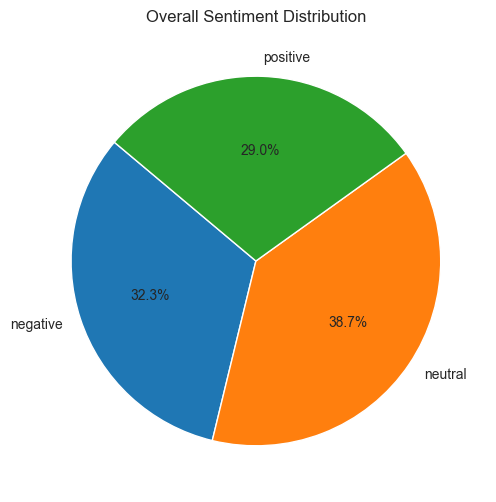

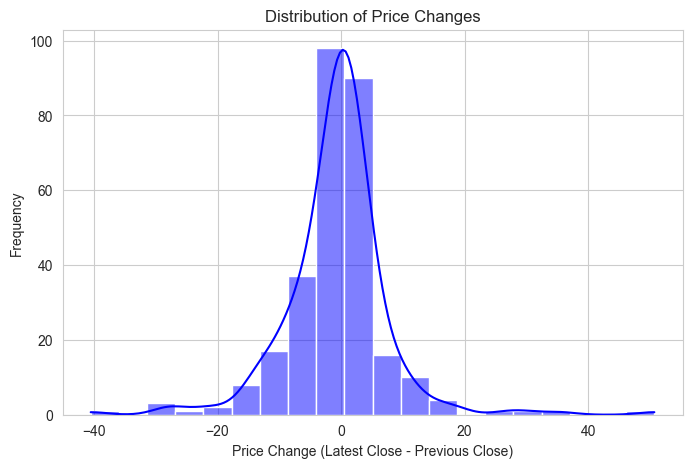

C:\Users\sajad\AppData\Local\Temp\ipykernel_22340\218667454.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=direction_counts.index, y=direction_counts.values, palette="viridis")


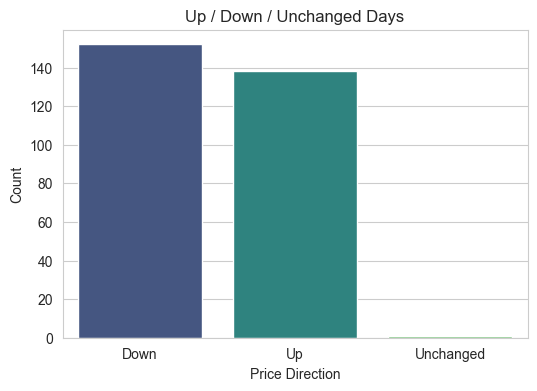

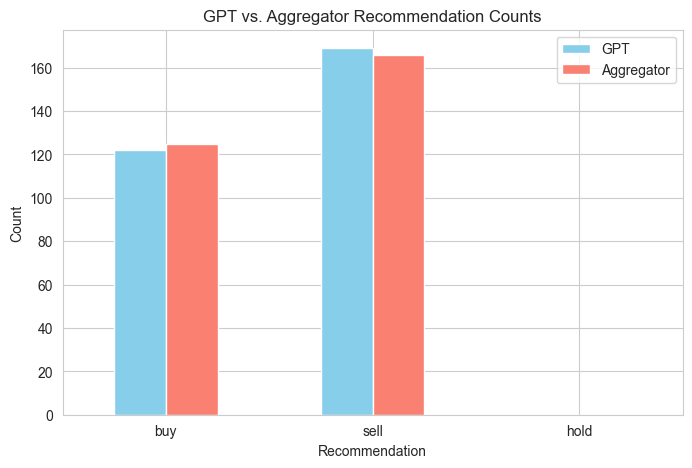

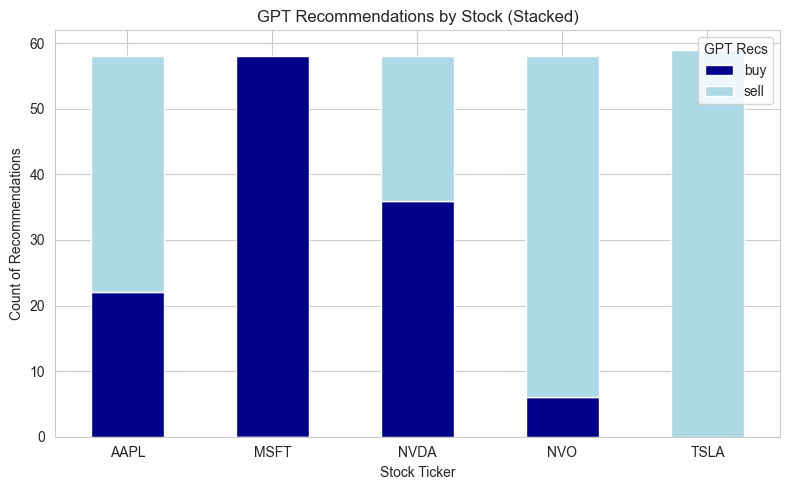

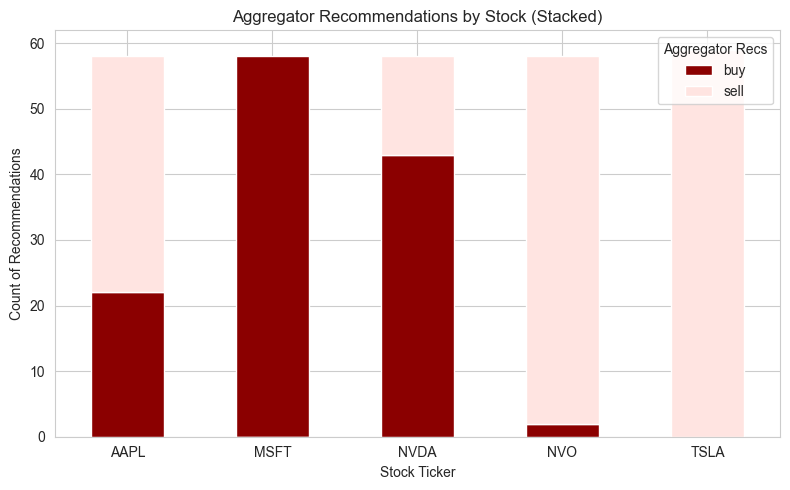

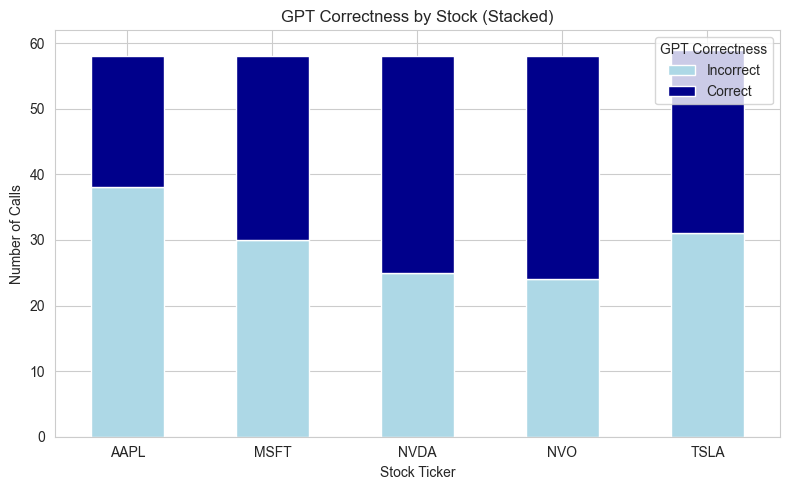

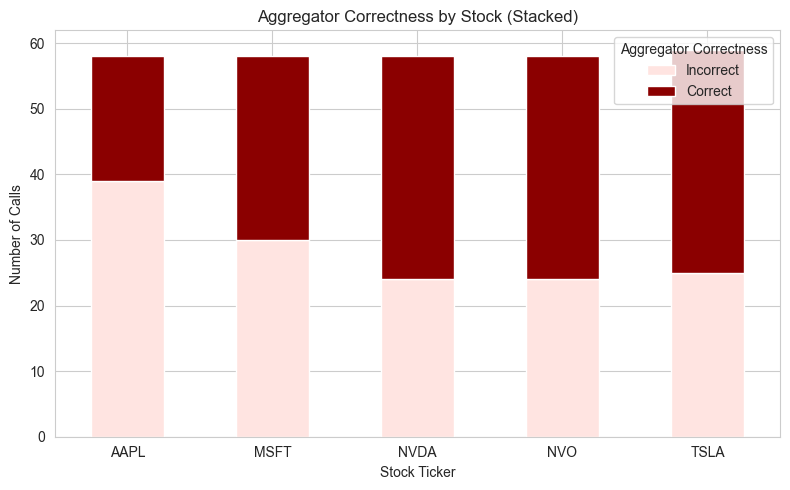

C:\Users\sajad\AppData\Local\Temp\ipykernel_22340\218667454.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=["skyblue", "salmon"])


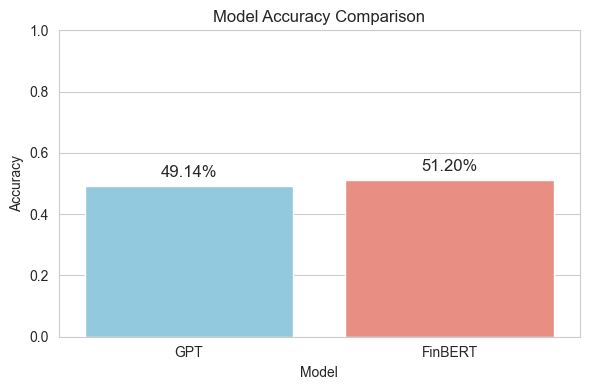

=== Accuracy Summary ===
GPT Accuracy: 49.14% (143 correct out of 291)
Aggregator Accuracy: 51.20% (149 correct out of 291)


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------- 0. LOAD & PREPARE DATA -------------
cleaned_file_path = "model_recommendations_cleaned2.csv"
df_cleaned = pd.read_csv(cleaned_file_path)

# Convert 'timestamp' to datetime
df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'])

# If 'sentiment_summary' is a string representation of a dict, parse it
if 'sentiment_summary' in df_cleaned.columns:
    df_cleaned['sentiment_dict'] = df_cleaned['sentiment_summary'].apply(eval)

# Normalize recommendation columns
df_cleaned['gpt_recommendation'] = df_cleaned['gpt_recommendation'].str.lower()
df_cleaned['aggregator_recommendation'] = df_cleaned['aggregator_recommendation'].str.lower()

# Setup plotting style
sns.set_style("whitegrid")
plt.rcParams.update({'figure.figsize': (8, 5)})

# ---------------------- PLOTTING FUNCTIONS ----------------------

def plot_sentiment_distribution(df):
    sentiment_df = pd.json_normalize(df['sentiment_dict'])
    if sentiment_df.empty:
        print("No sentiment_dict found or it's empty.")
        return

    sentiment_sums = sentiment_df.sum(numeric_only=True)
    plt.figure(figsize=(6, 6))
    sentiment_sums.plot(kind='pie', autopct='%1.1f%%', startangle=140, label='')
    plt.title("Overall Sentiment Distribution")
    plt.ylabel("")
    plt.show()

def plot_distribution_of_price_changes(df):
    df['price_change'] = df['latest_close'] - df['previous_close']
    plt.figure(figsize=(8,5))
    sns.histplot(df['price_change'], bins=20, kde=True, color="blue")
    plt.title("Distribution of Price Changes")
    plt.xlabel("Price Change (Latest Close - Previous Close)")
    plt.ylabel("Frequency")
    plt.show()

def plot_up_down_unchanged(df):
    if 'price_direction' not in df.columns:
        print("No 'price_direction' column found.")
        return
    direction_counts = df['price_direction'].value_counts()
    direction_label_map = {1: 'Up', -1: 'Down', 0: 'Unchanged'}
    direction_counts.index = direction_counts.index.map(direction_label_map)
    plt.figure(figsize=(6,4))
    sns.barplot(x=direction_counts.index, y=direction_counts.values, palette="viridis")
    plt.title("Up / Down / Unchanged Days")
    plt.xlabel("Price Direction")
    plt.ylabel("Count")
    plt.show()

def plot_gpt_vs_aggregator_counts(df):
    gpt_counts = df['gpt_recommendation'].value_counts()
    agg_counts = df['aggregator_recommendation'].value_counts()
    combined_df = pd.DataFrame({'GPT': gpt_counts, 'Aggregator': agg_counts}).fillna(0)
    combined_df = combined_df.reindex(['buy','sell','hold']).fillna(0)
    combined_df.plot(kind='bar', rot=0, color=['skyblue','salmon'])
    plt.title("GPT vs. Aggregator Recommendation Counts")
    plt.xlabel("Recommendation")
    plt.ylabel("Count")
    plt.legend(loc='best')
    plt.show()

def plot_recommendations_by_stock(df):
    # GPT Recommendation Counts by Stock
    gpt_recs = df.groupby(['stock_ticker', 'gpt_recommendation']).size().unstack(fill_value=0)
    gpt_recs = gpt_recs[['buy', 'sell']] if set(['buy', 'sell']).issubset(gpt_recs.columns) else gpt_recs
    gpt_recs.plot(kind='bar', stacked=True, figsize=(8,5), color=['darkblue', 'lightblue'])
    plt.title("GPT Recommendations by Stock (Stacked)")
    plt.xlabel("Stock Ticker")
    plt.ylabel("Count of Recommendations")
    plt.legend(title="GPT Recs")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Aggregator Recommendation Counts by Stock
    agg_recs = df.groupby(['stock_ticker', 'aggregator_recommendation']).size().unstack(fill_value=0)
    agg_recs = agg_recs[['buy', 'sell']] if set(['buy', 'sell']).issubset(agg_recs.columns) else agg_recs
    agg_recs.plot(kind='bar', stacked=True, figsize=(8,5), color=['darkred', 'mistyrose'])
    plt.title("Aggregator Recommendations by Stock (Stacked)")
    plt.xlabel("Stock Ticker")
    plt.ylabel("Count of Recommendations")
    plt.legend(title="Aggregator Recs")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_correctness_by_stock(df):
    if 'is_correct' in df.columns:
        gpt_correctness = df.groupby(["stock_ticker", "is_correct"])["is_correct"].count().unstack(fill_value=0)
        gpt_correctness.columns = ["Incorrect", "Correct"]
        plt.figure(figsize=(8, 5))
        gpt_correctness.plot(kind='bar', stacked=True, ax=plt.gca(), color=['lightblue','darkblue'])
        plt.title("GPT Correctness by Stock (Stacked)")
        plt.xlabel("Stock Ticker")
        plt.ylabel("Number of Calls")
        plt.legend(title="GPT Correctness")
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()

    if 'is_correct2' in df.columns:
        agg_correctness = df.groupby(["stock_ticker", "is_correct2"])["is_correct2"].count().unstack(fill_value=0)
        agg_correctness.columns = ["Incorrect", "Correct"]
        plt.figure(figsize=(8, 5))
        agg_correctness.plot(kind='bar', stacked=True, ax=plt.gca(), color=['mistyrose','darkred'])
        plt.title("Aggregator Correctness by Stock (Stacked)")
        plt.xlabel("Stock Ticker")
        plt.ylabel("Number of Calls")
        plt.legend(title="Aggregator Correctness")
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()

def plot_model_accuracy_comparison(df):
    accuracies = {}
    if 'is_correct' in df.columns:
        accuracies['GPT'] = df['is_correct'].mean()
    if 'is_correct2' in df.columns:
        accuracies['FinBERT'] = df['is_correct2'].mean()
    if not accuracies:
        print("No accuracy columns found in DataFrame.")
        return
    plt.figure(figsize=(6, 4))
    sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=["skyblue", "salmon"])
    plt.ylim(0, 1)
    for i, acc in enumerate(accuracies.values()):
        plt.text(i, acc + 0.02, f"{acc:.2%}", ha='center', va='bottom', fontsize=12)
    plt.title("Model Accuracy Comparison")
    plt.ylabel("Accuracy")
    plt.xlabel("Model")
    plt.tight_layout()
    plt.show()

    # --------------------- Accuracy Metrics ---------------------
    print("=== Accuracy Summary ===")
    if 'is_correct' in df_cleaned.columns:
        gpt_accuracy = df_cleaned['is_correct'].mean()
        print(f"GPT Accuracy: {gpt_accuracy:.2%} ({df_cleaned['is_correct'].sum()} correct out of {len(df_cleaned)})")

    if 'is_correct2' in df_cleaned.columns:
        aggregator_accuracy = df_cleaned['is_correct2'].mean()
        print(f"Aggregator Accuracy: {aggregator_accuracy:.2%} ({df_cleaned['is_correct2'].sum()} correct out of {len(df_cleaned)})")

# ---------------------- EXECUTE PLOTS ----------------------

plot_sentiment_distribution(df_cleaned)
plot_distribution_of_price_changes(df_cleaned)
plot_up_down_unchanged(df_cleaned)
plot_gpt_vs_aggregator_counts(df_cleaned)
plot_recommendations_by_stock(df_cleaned)  # <-- NEW FUNCTION
plot_correctness_by_stock(df_cleaned)
plot_model_accuracy_comparison(df_cleaned)


In [8]:
import pandas as pd
import numpy as np
from scipy.stats import binomtest, norm
from sklearn.metrics import precision_score, recall_score, f1_score

def map_recommendation(rec):
    if isinstance(rec, str):
        rec_lower = rec.lower()
        if 'buy' in rec_lower:
            return 1
        elif 'sell' in rec_lower:
            return -1
        elif 'hold' in rec_lower:
            return 0
    return 0

def run_statistical_tests(df, recommendation_col, correctness_col):
    """
    Perform statistical validation on a given recommendation column.
    """
    # Convert textual recommendation to numeric form for binary pass/fail stats
    df.loc[:, 'recommendation_numeric'] = df[recommendation_col].apply(map_recommendation)
    df.loc[:, 'is_correct'] = df[correctness_col]
    
    total_predictions = len(df)
    correct_predictions = df['is_correct'].sum()
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0.0
    
    # Assume a 0.50 baseline probability for correctness
    baseline_prob = 0.5
    
    # Binomial test
    p_binomial = binomtest(correct_predictions, total_predictions, p=baseline_prob, alternative='greater').pvalue
    
    # Confidence interval + z-test
    std_error = np.sqrt((accuracy * (1 - accuracy)) / total_predictions)
    z_score = norm.ppf(0.975)
    lower_bound = accuracy - z_score * std_error
    upper_bound = accuracy + z_score * std_error
    
    z_value = (accuracy - baseline_prob) / (std_error if std_error != 0 else 1)
    p_ztest = 2 * (1 - norm.cdf(abs(z_value)))
    
    return {
        "accuracy": accuracy,
        "confidence_interval": (lower_bound, upper_bound),
        "binomial_p_value": p_binomial,
        "z_test_p_value": p_ztest,
        "total_predictions": total_predictions,
        "correct_predictions": correct_predictions
    }

def compute_precision_recall(df, recommendation_col):
    """
    Compute precision, recall and f1 score for buy/sell recommendations.
    Hold rows are ignored for these metrics.
    """
    df_filtered = df[df[recommendation_col].str.lower().isin(['buy', 'sell'])]
    if df_filtered.empty:
        return {"precision": 0, "recall": 0, "f1_score": 0}
    
    # Map the actual price direction: 1 if price rose, -1 if price fell.
    y_true = df_filtered['price_direction'].apply(lambda x: 1 if x == 1 else -1)
    y_pred = df_filtered[recommendation_col].apply(map_recommendation)
    
    # 'buy' is treated as the positive class (pos_label=1)
    precision = precision_score(y_true, y_pred, average='binary', pos_label=1, zero_division=0)
    recall = recall_score(y_true, y_pred, average='binary', pos_label=1, zero_division=0)
    f1 = f1_score(y_true, y_pred, average='binary', pos_label=1, zero_division=0)
    
    return {"precision": precision, "recall": recall, "f1_score": f1}

def count_recommendation_types(df, recommendation_col):
    """Counts the number of Buy, Sell, and Hold recommendations."""
    counts = df[recommendation_col].str.lower().value_counts()
    return {
        "buy_count": counts.get('buy', 0),
        "sell_count": counts.get('sell', 0),
        "hold_count": counts.get('hold', 0)
    }

# ------------------- MAIN SCRIPT -------------------

# Load dataset
df = pd.read_csv("model_recommendations_cleaned2.csv")

# Ensure data consistency (boolean columns)
df['is_correct'] = df['is_correct'].astype(bool)
df['is_correct2'] = df['is_correct2'].astype(bool)

# 1. Run statistical tests for GPT and Aggregator recommendations
gpt_results = run_statistical_tests(df, "gpt_recommendation", "is_correct")
aggregator_results = run_statistical_tests(df, "aggregator_recommendation", "is_correct2")

# 2. Compute precision, recall & f1 score for GPT and Aggregator
gpt_metrics = compute_precision_recall(df, "gpt_recommendation")
aggregator_metrics = compute_precision_recall(df, "aggregator_recommendation")

# 3. Count the number of each recommendation type
gpt_counts = count_recommendation_types(df, "gpt_recommendation")
aggregator_counts = count_recommendation_types(df, "aggregator_recommendation")

# 4. Print summarized results
print("\nPerformance Summary")
print(f"GPT Accuracy: {gpt_results['accuracy']:.2%} "
      f"({gpt_results['correct_predictions']}/{gpt_results['total_predictions']}) "
      f"| Aggregator Accuracy: {aggregator_results['accuracy']:.2%} "
      f"({aggregator_results['correct_predictions']}/{aggregator_results['total_predictions']})\n")

print(f"GPT Binomial p-value: {gpt_results['binomial_p_value']:.4f} "
      f"| Aggregator Binomial p-value: {aggregator_results['binomial_p_value']:.4f}")
print(f"GPT Z-Test p-value: {gpt_results['z_test_p_value']:.4f} "
      f"| Aggregator Z-Test p-value: {aggregator_results['z_test_p_value']:.4f}\n")

print("Recommendation Counts")
print(f"GPT - Buy: {gpt_counts['buy_count']}, Sell: {gpt_counts['sell_count']}, Hold: {gpt_counts['hold_count']}")
print(f"Aggregator - Buy: {aggregator_counts['buy_count']}, Sell: {aggregator_counts['sell_count']}, Hold: {aggregator_counts['hold_count']}\n")

print("Precision, Recall & F1 Score")
print(f"GPT - Precision: {gpt_metrics['precision']:.2%}, Recall: {gpt_metrics['recall']:.2%}, F1 Score: {gpt_metrics['f1_score']:.2%}")
print(f"Aggregator - Precision: {aggregator_metrics['precision']:.2%}, Recall: {aggregator_metrics['recall']:.2%}, F1 Score: {aggregator_metrics['f1_score']:.2%}")



Performance Summary
GPT Accuracy: 49.14% (143/291) | Aggregator Accuracy: 51.20% (149/291)

GPT Binomial p-value: 0.6374 | Aggregator Binomial p-value: 0.3626
GPT Z-Test p-value: 0.7694 | Aggregator Z-Test p-value: 0.6815

Recommendation Counts
GPT - Buy: 122, Sell: 169, Hold: 0
Aggregator - Buy: 125, Sell: 166, Hold: 0

Precision, Recall & F1 Score
GPT - Precision: 48.36%, Recall: 42.75%, F1 Score: 45.38%
Aggregator - Precision: 48.80%, Recall: 44.20%, F1 Score: 46.39%
